In [ ]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as nm

#read csv file and removing the unnecessary column 
df=pd.read_csv('MSFT.csv')
df = df[['Date','Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9078,2022-03-18,300.429993
9079,2022-03-21,299.160004
9080,2022-03-22,304.059998
9081,2022-03-23,299.489990


In [ ]:
#function for converting the date value which is of type object to integer
import datetime
def str_to_datetime(s):
    split=s.split('-')
    year,month,day=int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [ ]:
#passing the function to convert the datatype of df to integer
df['Date']=df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9078   2022-03-18
9079   2022-03-21
9080   2022-03-22
9081   2022-03-23
9082   2022-03-24
Name: Date, Length: 9083, dtype: datetime64[ns]

In [ ]:
df.index=df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-03-18,300.429993
2022-03-21,299.160004
2022-03-22,304.059998


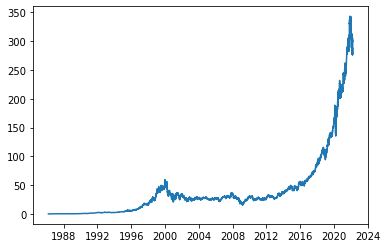

In [ ]:
plt.plot(df.index, df['Close'])

In [ ]:
#for converting to supervised learning problem
#here one target day is given and three previous val target-3, target-1 and 
#target-1 and curr val

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = nm.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2020-12-25', 
                                '2021-12-01', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-12-25,222.589996,223.940002,221.020004,222.750000
1,2020-12-29,221.020004,222.750000,224.960007,224.149994
2,2020-12-30,222.750000,224.960007,224.149994,221.679993
3,2020-12-31,224.960007,224.149994,221.679993,222.419998
4,2021-01-04,224.149994,221.679993,222.419998,217.690002
...,...,...,...,...,...
230,2021-11-24,343.109985,339.829987,337.679993,337.910004
231,2021-11-26,339.829987,337.679993,337.910004,329.679993
232,2021-11-29,337.679993,337.910004,329.679993,336.630005
233,2021-11-30,337.910004,329.679993,336.630005,330.589996


In [ ]:
#converting above data to numpy arrays to directly feed into tensorflow model
#x id 3d array i.e. all three previous value and y is output factor(target)
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(nm.float32), Y.astype(nm.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((235,), (235, 3, 1), (235,))

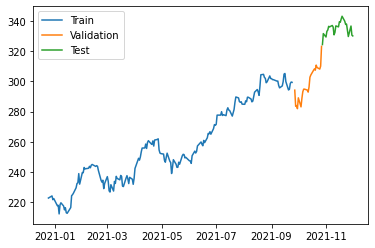

In [ ]:
#testing, validation and training data partition
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
#create and train our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
6/6 [==============================] - 2s 79ms/step - loss: 67376.4922 - mean_absolute_error: 258.2650 - val_loss: 89082.1016 - val_mean_absolute_error: 298.2724
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 67225.0938 - mean_absolute_error: 257.9733 - val_loss: 88916.2656 - val_mean_absolute_error: 297.9943
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 67088.6562 - mean_absolute_error: 257.7078 - val_loss: 88780.4531 - val_mean_absolute_error: 297.7664
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 66982.1328 - mean_absolute_error: 257.5006 - val_loss: 88660.6172 - val_mean_absolute_error: 297.5650
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 66861.1797 - mean_absolute_error: 257.2643 - val_loss: 88483.6953 - val_mean_absolute_error: 297.2675
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 66678.4453 - mean_absolute_error: 256.9100 - val_loss: 88229.39

6/6 [==============================] - 0s 2ms/step


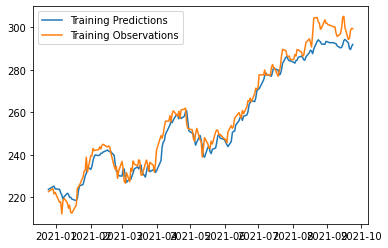

In [ ]:
#plotting graph for the data 
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 13ms/step


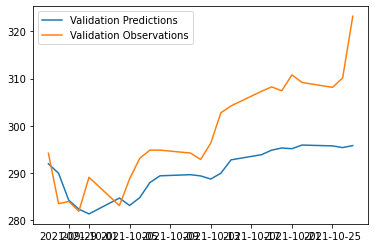

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 16ms/step


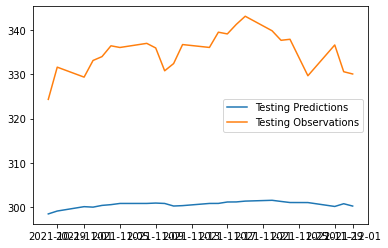

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

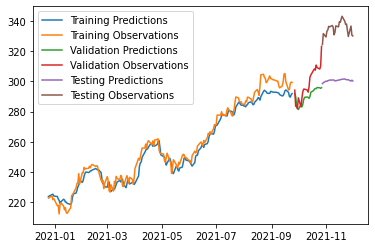

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = nm.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(nm.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 13ms/step


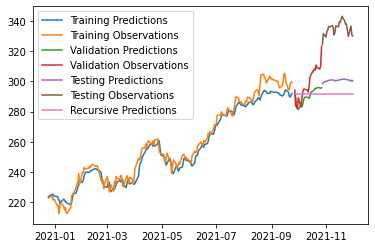

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
